# 🚀 NexoraGuard: Customer Service Chatbot 🚀
## A RAG-Powered Chatbot Journey

**Presented by: Sujan Adhikari**
**Date: 13 May 2025**

<div align="center">

```mermaid
%%{init: { 
      'themeVariables': { 'fontSize': '1px' }   /* 16 px → 10 px ≈ 70 % */
    }}%%
graph TD
    A[User Enters Query] --> B{NLU: Intent & Key Entity Extraction};
    
    subgraph "Knowledge Acquisition & Preparation (Offline/Periodic)"
        direction LR
        C1["Data Sources (FAQs, Product Docs)"] --> C2["Data Cleaning & Structuring"];
        C2 --> C3["Text Embedding (mxbai-embed-large)"];
        C3 --> C4["Vector Store (ChromaDB)"];
    end

    B -- "Greeting / Farewell / Ask Agent" --> X[Pre-built Response & Contact Info];
    B -- "Info / Quote / Coverage" --> P[Query Refinement & Business Logic];
    
    P --> D{RAG Core Engine};
    
    subgraph "RAG Core Engine (Per Query)"
        direction TB
        E1["Query Embedding"]; 
        C4 --- E1;
        E1 --> E2["Semantic Search in Vector Store"];
        E2 -- "Relevant Docs (Context)" --> E3["Prompt Augmentation"];
        P -- "Refined Query" --> E3;
        E3 --> E4["LLM (gemma3:4b) for Generation"];
    end

    D --> F["Generated Answer (Grounded in Context)"];
    F --> G{Response Formatting & Safety Checks};
    G --> H[NexoraGuard Presents Answer to User];

    %% Styling
    style A fill:#FFFFE0,stroke:#B8860B,stroke-width:2px,color:#000
    style B fill:#F0E68C,stroke:#DAA520,stroke-width:2px,color:#000
    style C1 fill:#FFDEAD,stroke:#333,stroke-width:1.5px,color:#333
    style C2 fill:#FFE4B5,stroke:#333,stroke-width:1.5px,color:#333
    style C3 fill:#FFC0CB,stroke:#DB7093,stroke-width:1.5px,color:#000
    style C4 fill:#D8BFD8,stroke:#8A2BE2,stroke-width:2px,color:#000
    style D fill:#ADD8E6,stroke:#4682B4,stroke-width:2px,color:#000
    style E1 fill:#DCDCDC,stroke:#A9A9A9,stroke-width:1px,color:#000
    style E2 fill:#DCDCDC,stroke:#A9A9A9,stroke-width:1px,color:#000
    style E3 fill:#DCDCDC,stroke:#A9A9A9,stroke-width:1px,color:#000
    style E4 fill:#90EE90,stroke:#3CB371,stroke-width:1.5px,color:#000
    style F fill:#FFB6C1,stroke:#FF69B4,stroke-width:1.5px,color:#000
    style G fill:#E0FFFF,stroke:#00CED1,stroke-width:1.5px,color:#000
    style H fill:#98FB98,stroke:#2E8B57,stroke-width:2px,color:#000
    style P fill:#E6E6FA,stroke:#9370DB,stroke-width:1.5px,color:#000
    style X fill:#FFFACD,stroke:#DAA520,stroke-width:2px,color:#000
```
</div>

## 📜 Table of Contents

2.  [📊 **Phase 1: Know Thy Data - The Bedrock of Intelligence (Pre-RAG Analysis)**](#phase1)
    *   Why Data Profiling is Non-Negotiable
    *   Peeking into `faqs_cleaned.csv`
        *   Dataset Overview & Initial Cleaning
        *   Category Distribution: What are customers asking about?
        *   Duplicate Questions: A Quality Hazard
        *   Content Lengths: Implications for Embedding
    *   Unpacking `products_occupation.json`
        *   Dataset Structure: Products & Occupations
        *   Content Volume: How much info per entry?
        *   Risk vs. Claim Likelihood: Any correlation?
        *   Product Recommendation Hotspots
    *   Glimpse into `chat_conversations.json`: Future Goldmine
    *   Key Takeaways from Data Profiling
3.  [🛠️ **Phase 2: Architecting Intelligence - Building NexoraGuard**](#phase2)
    *   What is RAG? A 10,000-foot view
    *   The Blueprint: NexoraGuard's Architecture
    *   Step-by-Step Construction:
        1.  The Toolkit: Libraries, Models & Configs
        2.  Ingesting Wisdom: Preparing Product & FAQ Data
        3.  The Memory Palace: Vector Store with ChromaDB
        4.  The Mind Reader: Intent & Entity Recognition with SpaCy
        5.  The Oracle: Crafting the RAG Chain & Persona-Driven Prompts
4.  [🤖 **Phase 3: NexoraGuard Unveiled - Live Demonstration!**](#phase3)

---
<a id="phase1"></a>
## 📊 Phase 1: Know Thy Data - (Pre-RAG Analysis)

**(Both Audiences):** Before we can build an intelligent system, we must deeply understand the data it will learn from. This pre-analysis phase is crucial for identifying potential issues, understanding data characteristics.

We'll be exploring two primary knowledge sources:
*   `faqs_cleaned.csv`: Customer frequently asked questions.
*   `products_occupation.json`: Detailed information on insurance products and relevant occupations.

And we'll take a quick peek at `chat_conversations.json` for future potential.

### Why Data Profiling is Non-Negotiable

*   **Quality Control:** Identify and address inconsistencies, duplicates, or missing information. Garbage in, garbage out!
*   **Strategy Formulation:** Determine how to best structure and process data for optimal retrieval (e.g., do we need to split long documents? How do we handle different data types?).
*   **Insight Generation:** Uncover patterns and statistics that can inform chatbot behavior and prioritization.

Let's dive in!

In [22]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import csv
from pathlib import Path
import shutil # For managing directories if needed
from IPython.display import display, HTML # For better DataFrame rendering

# Configure plots
plt.rcParams['figure.figsize'] = (10, 5) # Adjusted for better presentation

# Ensure data directory exists for the script to run
DATA_DIR_PRE_ANALYSIS = Path('data')
DATA_DIR_PRE_ANALYSIS.mkdir(parents=True, exist_ok=True)

# Helper function to display DataFrames nicely in a presentation
def display_df(df, title="DataFrame"):
    # print(f"\n--- {title} ---")
    if isinstance(df, pd.Series):
        # For Series, convert to DataFrame for better display with title
        display(HTML(f"<h3>{title}</h3>"))
        display(df.to_frame())
    else:
        display(HTML(f"<h3>{title}</h3>"))
        display(df)

print("Pre-analysis setup complete. Necessary libraries imported and data directory ensured.")


Pre-analysis setup complete. Necessary libraries imported and data directory ensured.


### Peeking into `faqs_cleaned.csv`

This file contains curated question-answer pairs, a prime candidate for direct retrieval.

#### Dataset Overview & Initial Cleaning
The original `faqs.csv` had some formatting issues, particularly unquoted commas within the question text. We've implemented a robust cleaning step.

In [23]:
# for FAQ cleaning and loading
FAQS_FILE = DATA_DIR_PRE_ANALYSIS / 'faqs.csv'
FAQS_CLEANED_FILE = DATA_DIR_PRE_ANALYSIS / 'faqs_cleaned.csv'

with open(FAQS_FILE, "r", encoding="utf-8") as infile, \
    open(FAQS_CLEANED_FILE, "w", newline="", encoding="utf-8") as outfile:
    reader = csv.reader(infile)
    csv_writer_obj = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)

    try:
        header = next(reader)
        csv_writer_obj.writerow(header)

        for row in reader:
            if not row: continue # Skip empty rows
            if len(row) > 3: # Question field likely contains unquoted commas
                question_parts = row[:-2]
                question = ",".join(question_parts).strip('" ') # Join and strip quotes/spaces
                answer = row[-2].strip('" ')
                category = row[-1].strip('" ')
                csv_writer_obj.writerow([question, answer, category])
            elif len(row) == 3:
                csv_writer_obj.writerow([col.strip('" ') for col in row])
            else:
                print(f"Skipping malformed FAQ row: {row}") # Log malformed rows
    except StopIteration:
        print(f"Warning: {FAQS_FILE} might be empty or just has a header.")
        # Ensure header is written even if file is empty after header
        if 'header' not in locals() or not header: header = ['question', 'answer', 'category']
        if header: csv_writer_obj.writerow(header) # Check if header itself was read
    except Exception as e:
        print(f"An error occurred during FAQ cleaning: {e}")
        # Create an empty cleaned file with header if error
        if 'header' not in locals() or not header: header = ['question', 'answer', 'category']
        if header: csv_writer_obj.writerow(header)


try:
    df_faq = pd.read_csv(FAQS_CLEANED_FILE)
    print(f"Successfully loaded {FAQS_CLEANED_FILE}")
    display_df(df_faq.head(), title=f"First 5 Rows of FAQs ({FAQS_CLEANED_FILE.name})")
    print(f"\nFAQ rows, columns: {df_faq.shape}")
except pd.errors.EmptyDataError:
    print(f"Error: {FAQS_CLEANED_FILE} is empty or could not be read. Please check the cleaning process.")
    df_faq = pd.DataFrame(columns=['question', 'answer', 'category']) # Empty df to prevent downstream errors
except Exception as e:
    print(f"An error occurred loading the cleaned FAQ CSV: {e}")
    df_faq = pd.DataFrame(columns=['question', 'answer', 'category'])

print("\n**Outcome:** We now have a clean, structured DataFrame of FAQs. The shape tells us the volume of FAQs.")


Successfully loaded data\faqs_cleaned.csv


,question,answer,category
0,How do I get a copy of my policy documents or ...,Log into your Nexora account to view and downl...,Account
1,How do I make an amendment to my policy?,"Log into your Nexora account, locate the polic...",Account
2,How do I update my payment details?,Log into your Nexora account and click 'Update...,Account
3,"My payment has failed, how do I make payment?",Use the 'Retry' or 'Reschedule' button in the ...,Account
4,How do I create a new login?,"Click on the 'Recover Password' link, enter yo...",Account



FAQ rows, columns: (130, 3)

**Outcome:** We now have a clean, structured DataFrame of FAQs. The shape tells us the volume of FAQs.


#### Category Distribution: What are customers asking about?
Understanding the distribution of FAQs by category helps us see common areas of inquiry.

*   **Why is this useful?** It can guide content creation, identify areas where customers need more clarity, and help in routing queries if we build more complex logic.

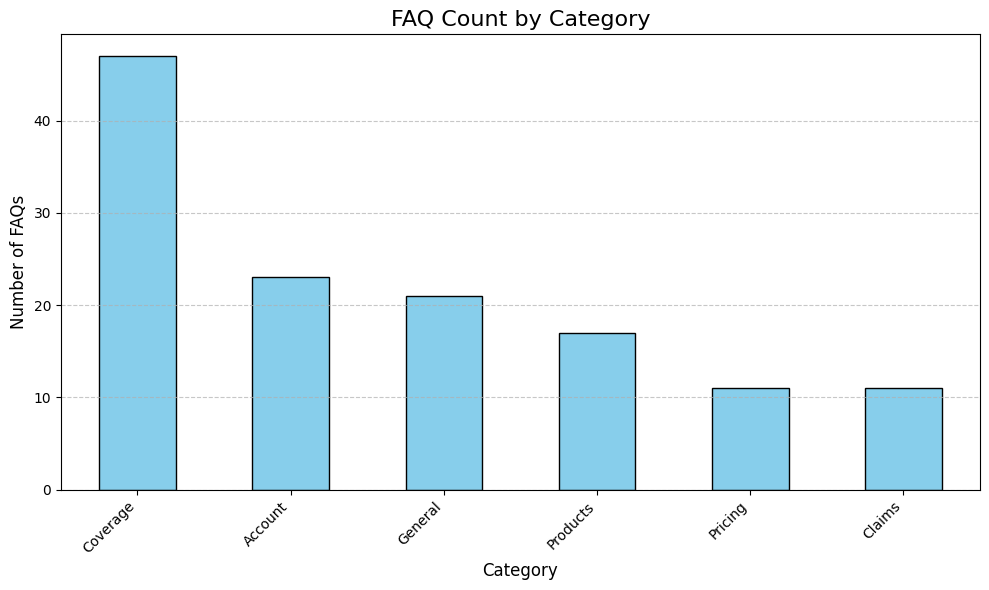


**Outcome & Insight:** The bar chart vividly shows which categories have the most FAQs. This helps us anticipate common user needs.


In [24]:
# Code from pre_rag_analysis.ipynb for category distribution
if not df_faq.empty and 'category' in df_faq.columns:
    faq_cat_counts = df_faq['category'].value_counts()

    plt.figure(figsize=(10,6)) # Adjusted for better readability
    faq_cat_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title("FAQ Count by Category", fontsize=16)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Number of FAQs", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("FAQ DataFrame is empty or 'category' column is missing. Skipping category distribution plot.")

print("\n**Outcome & Insight:** The bar chart vividly shows which categories have the most FAQs. This helps us anticipate common user needs.")


#### Duplicate Questions: A Quality Hazard
Duplicate questions can lead to confusion if they have different answers or simply clutter the knowledge base.

*   **Why care about duplicates?** The RAG retriever might surface multiple, potentially conflicting, answers for the same query, degrading user trust.
*   **How do we find them?** `pandas.DataFrame.duplicated()` is our friend.

In [25]:
# Code from pre_rag_analysis.ipynb for duplicate questions
if not df_faq.empty and 'question' in df_faq.columns:
    # Ensure 'question' column is string type to avoid errors with .nunique() if there are non-string values
    df_faq['question'] = df_faq['question'].astype(str)
    
    dupes_mask = df_faq.duplicated('question', keep=False)
    df_dupes = df_faq[dupes_mask]

    num_duplicated_questions = df_dupes['question'].nunique()
    print(f"\nNumber of unique question texts that are duplicated: {num_duplicated_questions}")

    if not df_dupes.empty:
        display_df(df_dupes[['question','category']].sort_values('question').head(), title="Sample Duplicated Questions")
    else:
        print("No duplicated questions found.")
else:
    print("FAQ DataFrame is empty or 'question' column is missing. Skipping duplicate question check.")



Number of unique question texts that are duplicated: 8


,question,category
26,Can I cancel my policy?,Account
63,Can I cancel my policy?,Account
94,Do Specialty Retailers need professional indem...,Coverage
96,Do Specialty Retailers need professional indem...,Coverage
14,How do I get a quote?,General


#### Content Lengths: Implications for Embedding
The length of questions and answers can affect how they are embedded and processed by the LLM.

*   **Why measure length?** Extremely long texts might exceed token limits for embedding models or LLM context windows. Very short texts might lack context.
*   **How?** Character counts give a good proxy.

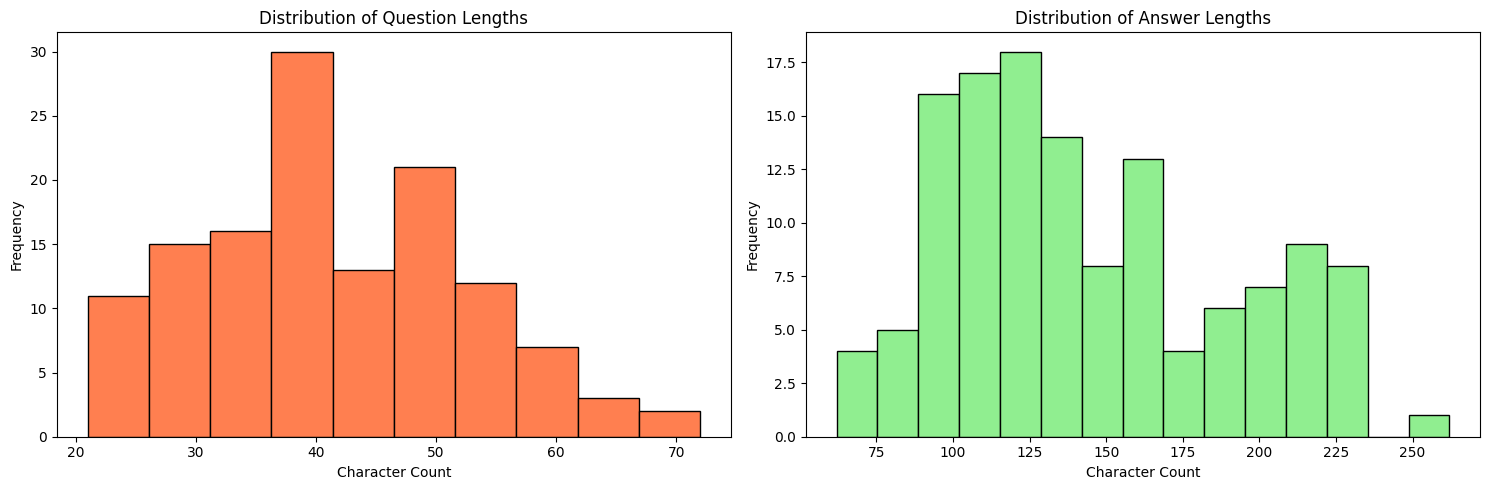



**Outcome & Insight:**
    This means each Q-A pair can likely be embedded as a single unit without needing complex "chunking" strategies. 
    This simplifies our RAG pipeline.



In [26]:
# Code from pre_rag_analysis.ipynb for length stats
if not df_faq.empty and 'question' in df_faq.columns and 'answer' in df_faq.columns:
    df_faq['question_length'] = df_faq['question'].astype(str).str.len()
    df_faq['answer_length']   = df_faq['answer'].astype(str).str.len()
    
    length_stats = df_faq[['question_length','answer_length']].describe().round(2)
    # display_df(length_stats, title="Descriptive Statistics for FAQ Q&A Lengths (Characters)")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    if 'question_length' in df_faq.columns:
        df_faq['question_length'].plot(kind='hist', bins=10, ax=axes[0], color='coral', edgecolor='black', title='Distribution of Question Lengths')
        axes[0].set_xlabel('Character Count')
        axes[0].set_ylabel('Frequency')

    if 'answer_length' in df_faq.columns:
        df_faq['answer_length'].plot(kind='hist', bins=15, ax=axes[1], color='lightgreen', edgecolor='black', title='Distribution of Answer Lengths')
        axes[1].set_xlabel('Character Count')
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

else:
    print("FAQ DataFrame is empty or lacks 'question'/'answer' columns. Skipping length analysis.")

print('''
\n**Outcome & Insight:**
    This means each Q-A pair can likely be embedded as a single unit without needing complex "chunking" strategies. 
    This simplifies our RAG pipeline.
''')


### Unpacking `products_occupation.json`
This file is a richer, structured JSON containing details about insurance products and how they relate to different occupations.

In [27]:
# Code from pre_rag_analysis.ipynb for products_occupation.json
PRODUCTS_OCCUPATION_FILE = DATA_DIR_PRE_ANALYSIS / 'products_occupation.json'

prod_occ_data = {}
try:
    with open(PRODUCTS_OCCUPATION_FILE, 'r', encoding='utf-8') as f:
        prod_occ_data = json.load(f)

    df_products = pd.json_normalize(prod_occ_data.get('products', []))
    df_occ = pd.json_normalize(prod_occ_data.get('occupation_data', []))
    
    print(f"Products rows, columns: {df_products.shape}")
    if not df_products.empty:
        print(f"Products columns: {df_products.columns.tolist()}")
        display_df(df_products.head(2), f"Sample Product Data ({PRODUCTS_OCCUPATION_FILE.name})")
    else:
        print("No product data loaded.")
        
    print(f"\nOccupation rows, columns: {df_occ.shape}")
    if not df_occ.empty:
        print(f"Occupation columns: {df_occ.columns.tolist()}")
        display_df(df_occ.head(2), f"Sample Occupation Data ({PRODUCTS_OCCUPATION_FILE.name})")
    else:
        print("No occupation data loaded.")

except FileNotFoundError:
    print(f"Error: {PRODUCTS_OCCUPATION_FILE} not found. Please ensure the file exists.")
    df_products = pd.DataFrame()
    df_occ = pd.DataFrame()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {PRODUCTS_OCCUPATION_FILE}. Please check its format.")
    df_products = pd.DataFrame()
    df_occ = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred with {PRODUCTS_OCCUPATION_FILE.name}: {e}")
    df_products = pd.DataFrame()
    df_occ = pd.DataFrame()

print("\n**Outcome:** We see the shape and rich column set for both products and occupations. This structured data is gold for our RAG system.")


Products rows, columns: (6, 15)
Products columns: ['product_id', 'name', 'description', 'target_industries', 'coverage_options', 'key_features', 'exclusions', 'unique_selling_points', 'required_documents', 'premium_range.min', 'premium_range.max', 'premium_range.currency', 'excess_range.min', 'excess_range.max', 'excess_range.currency']


,product_id,name,description,target_industries,coverage_options,key_features,exclusions,unique_selling_points,required_documents,premium_range.min,premium_range.max,premium_range.currency,excess_range.min,excess_range.max,excess_range.currency
0,PROD-859d85ba,Professional Indemnity,Covers companies for claims made by clients fo...,"[Consulting, IT Services, Legal Services, Acco...","[$1M, $2M, $5M, $10M, $20M]","[Legal representation at inquiries, Covers bre...","[Prior known claims, Intentional acts, Fraudul...","[Tailored for your specific profession, Retroa...","[Business details, Claims history, Revenue inf...",500,3000,AUD,500,2500,AUD
1,PROD-9a5e1ec7,Public Liability,Covers organizations against legal liability f...,"[Retail, Hospitality, Construction, Events, Ma...","[$5M, $10M, $20M, $50M]","[Products liability coverage, Advertising inju...","[Professional advice, Employee injuries, Contr...","[No hidden fees, Fast certificate of currency,...","[Business details, Claims history, Revenue inf...",300,2000,AUD,500,1500,AUD



Occupation rows, columns: (91, 5)
Occupation columns: ['industry', 'occupation', 'risk_level', 'recommended_products', 'claim_likelihood']


,industry,occupation,risk_level,recommended_products,claim_likelihood
0,Accounting,Accountant,1.9,"[Professional Indemnity, Business Insurance, C...",0.016
1,Accounting,Bookkeeper,2.2,"[Professional Indemnity, Business Insurance, C...",0.132



**Outcome:** We see the shape and rich column set for both products and occupations. This structured data is gold for our RAG system.


#### Content Volume: How much info per entry?
Similar to FAQs, we'll check character counts for product and occupation entries (as JSON strings).

*   **Why?** To confirm they are suitable for embedding without excessive chunking.

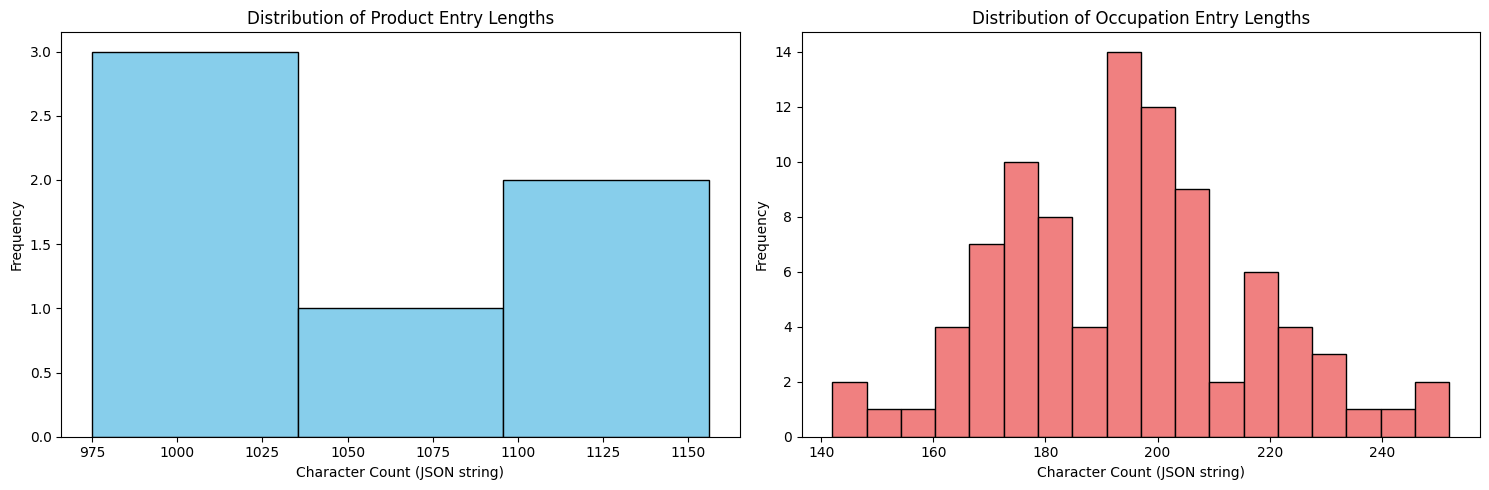

In [28]:
# Code from pre_rag_analysis.ipynb for product/occupation lengths
if 'products' in prod_occ_data and 'occupation_data' in prod_occ_data:
    product_lengths = [
        len(json.dumps(prod, ensure_ascii=False))
        for prod in prod_occ_data.get('products', [])
    ]
    occupation_lengths = [
        len(json.dumps(occ, ensure_ascii=False))
        for occ in prod_occ_data.get('occupation_data', [])
    ]

    df_prod_occ_lengths_desc = pd.DataFrame({
        'product_char_count': pd.Series(product_lengths),
        'occupation_char_count': pd.Series(occupation_lengths)
    })

    if not df_prod_occ_lengths_desc.empty:
        stats_prod_occ_lengths = df_prod_occ_lengths_desc.describe().round(2)
        # display_df(stats_prod_occ_lengths, "Descriptive Statistics for Product/Occupation JSON String Lengths")

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        df_prod_occ_lengths_desc['product_char_count'].dropna().plot(kind='hist', bins=max(1, len(product_lengths)//2 or 1), ax=axes[0], color='skyblue', edgecolor='black', title='Distribution of Product Entry Lengths')
        axes[0].set_xlabel('Character Count (JSON string)')
        axes[0].set_ylabel('Frequency')

        df_prod_occ_lengths_desc['occupation_char_count'].dropna().plot(kind='hist', bins=max(1, len(occupation_lengths)//5 or 1), ax=axes[1], color='lightcoral', edgecolor='black', title='Distribution of Occupation Entry Lengths')
        axes[1].set_xlabel('Character Count (JSON string)')
        axes[1].set_ylabel('Frequency')
    
        plt.tight_layout()
        plt.show()
    else:
        print("Product/Occupation length data is empty. Skipping plots.")
else:
    print("Could not find 'products' or 'occupation_data' in loaded JSON. Skipping length analysis.")


#### Risk vs. Claim Likelihood: Any correlation?
The occupations data has `risk_level` (1-5 ordinal) and `claim_likelihood` (continuous). Are they redundant?

*   **Why check?** If highly correlated, we might only need one. If not, both offer unique information.


Correlation between 'risk_level' and 'claim_likelihood': 0.065


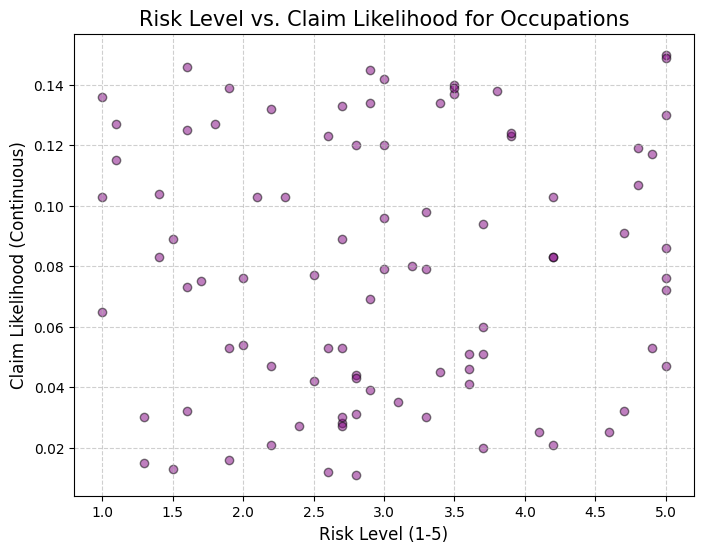



**Outcome & Insight:** Low correlation (e.g., 0.065 in original notebook) suggests distinct information.
*   **Decision:** Both fields offer unique perspectives on risk and should be kept for richer data.



In [29]:
# Code from pre_rag_analysis.ipynb for correlation
if not df_occ.empty and 'risk_level' in df_occ.columns and 'claim_likelihood' in df_occ.columns:
    df_occ_corr = df_occ.copy() # Avoid SettingWithCopyWarning
    df_occ_corr['risk_level'] = pd.to_numeric(df_occ_corr['risk_level'], errors='coerce')
    df_occ_corr['claim_likelihood'] = pd.to_numeric(df_occ_corr['claim_likelihood'], errors='coerce')
    
    # Drop NA values that might have been introduced by coerce before calculating correlation
    df_occ_corr_cleaned = df_occ_corr.dropna(subset=['risk_level', 'claim_likelihood'])
    
    if not df_occ_corr_cleaned.empty:
        correlation = df_occ_corr_cleaned['risk_level'].corr(df_occ_corr_cleaned['claim_likelihood']).round(3)
        print(f"\nCorrelation between 'risk_level' and 'claim_likelihood': {correlation}")

        plt.figure(figsize=(8,6))
        plt.scatter(df_occ_corr_cleaned['risk_level'], df_occ_corr_cleaned['claim_likelihood'], alpha=0.5, color='purple', edgecolor='black')
        plt.title('Risk Level vs. Claim Likelihood for Occupations', fontsize=15)
        plt.xlabel('Risk Level (1-5)', fontsize=12)
        plt.ylabel('Claim Likelihood (Continuous)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("Not enough valid data points to calculate correlation or plot.")
else:
    print("Occupation DataFrame is empty or lacks 'risk_level'/'claim_likelihood'. Skipping correlation analysis.")

print('''
\n**Outcome & Insight:** Low correlation (e.g., 0.065 in original notebook) suggests distinct information.
*   **Decision:** Both fields offer unique perspectives on risk and should be kept for richer data.
''')


#### Product Recommendation Hotspots
Which products are most frequently recommended across different occupations?

*   **Why is this important?** Tells us which products are broadly applicable. NexoraGuard should be particularly knowledgeable about these.

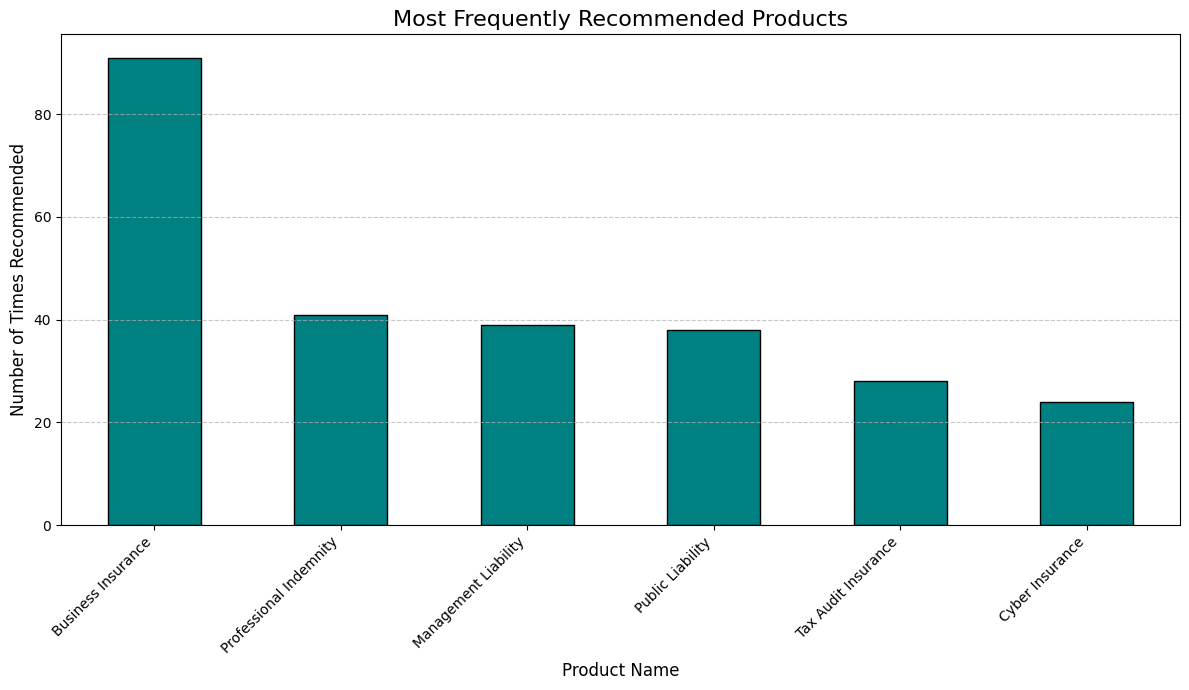



**Outcome & Insight:** This table and chart highlight core products.



In [30]:
if not df_occ.empty and 'recommended_products' in df_occ.columns:
    df_occ_recs = df_occ.copy()
    df_occ_recs_cleaned = df_occ_recs.dropna(subset=['recommended_products'])
    
    def to_list_if_str(item):
        if isinstance(item, str):
            try: # Try parsing as JSON list first (e.g., '["Product A", "Product B"]')
                parsed_item = json.loads(item.replace("'", '"'))
                return parsed_item if isinstance(parsed_item, list) else [parsed_item]
            except json.JSONDecodeError: # Fallback for simple comma-separated (e.g., 'Product A, Product B')
                return [x.strip() for x in item.split(',')]
        return item if isinstance(item, list) else []

    try:
        # Apply the conversion robustly
        df_occ_recs_cleaned['recommended_products_list'] = df_occ_recs_cleaned['recommended_products'].apply(to_list_if_str)
        
        all_recommended_products = list(itertools.chain.from_iterable(
            df_occ_recs_cleaned['recommended_products_list']
        ))
        
        if all_recommended_products:
            from collections import Counter # Ensure Counter is available
            prod_counts = Counter(all_recommended_products)
            df_prod_counts = pd.Series(prod_counts).sort_values(ascending=False).to_frame('count')
            # display_df(df_prod_counts, title="Product Recommendation Frequency Across Occupations")

            plt.figure(figsize=(12,7))
            df_prod_counts['count'].plot(kind='bar', color='teal', edgecolor='black')
            plt.title('Most Frequently Recommended Products', fontsize=16)
            plt.xlabel('Product Name', fontsize=12)
            plt.ylabel('Number of Times Recommended', fontsize=12)
            plt.xticks(rotation=45, ha="right", fontsize=10)
            plt.yticks(fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("No recommended products found after processing.")
            
    except Exception as e:
        print(f"Error processing recommended products: {e}.")
        print("Sample data in 'recommended_products':")
        print(df_occ_recs_cleaned['recommended_products'].head() if not df_occ_recs_cleaned.empty else "N/A")

else:
    print("Occupation DataFrame is empty or 'recommended_products' column is missing. Skipping product recommendation analysis.")

print('''
\n**Outcome & Insight:** This table and chart highlight core products.
''')


### Glimpse into `chat_conversations.json`
This file contains chat logs, a valuable (but less structured) source for future enhancements.

In [31]:
# Code from pre_rag_analysis.ipynb for chat conversation analysis
CHAT_CONVERSATIONS_FILE = DATA_DIR_PRE_ANALYSIS / 'chat_conversations.json'

# Create a dummy chat_conversations.json if it doesn't exist
if not CHAT_CONVERSATIONS_FILE.exists():
    print(f"Warning: {CHAT_CONVERSATIONS_FILE} not found. Creating a dummy file.")
    dummy_chat_data = [
        {
            "id": "conv_658aa0c1", "timestamp": "2023-12-21T10:00:00Z",
            "messages": [
                {"role": "customer", "text": "Hi, what insurance do I need as a IT Consultant?"},
                {"role": "agent", "text": "As a IT Consultant in the IT Services industry, you should consider Tax Audit Insurance, Business Insurance, Management Liability insurance. The exact coverage needed depends on your specific business operations and risks."}
            ]
        },
        {
            "id": "conv_658aa0c2", "timestamp": "2023-12-21T10:05:00Z",
            "messages": [
                {"role": "customer", "text": "How much is public liability?"},
                {"role": "agent", "text": "The premium for Public Liability depends on various factors like your business type, size, and location. Could you provide more details?"}
            ]
        }
    ]
    with open(CHAT_CONVERSATIONS_FILE, 'w', encoding='utf-8') as f:
        json.dump(dummy_chat_data, f, indent=2)

potential_new_qas = []
if CHAT_CONVERSATIONS_FILE.exists():
    with open(CHAT_CONVERSATIONS_FILE, 'r', encoding='utf-8') as f:
        try:
            chat_data_list = json.load(f)
            print(f"\nLoaded {len(chat_data_list)} chat conversations from {CHAT_CONVERSATIONS_FILE.name}.")
            
            for conv in chat_data_list:
                messages = conv.get('messages', [])
                for i in range(len(messages) - 1):
                    if messages[i].get('role') == 'customer' and messages[i+1].get('role') == 'agent':
                        q = messages[i].get('text','')
                        a = messages[i+1].get('text','')
                        if len(q) > 10 and len(a) > 10 and ("?" in q or any(kw in q.lower() for kw in ["what", "how", "do i", "can i", "tell me"])):
                             potential_new_qas.append({
                                 "question": q, "answer": a, "source_conversation_id": conv.get("id")
                             })
            
            print(f"Identified {len(potential_new_qas)} potential Q&A pairs from chat logs for review.")
            if potential_new_qas:
                display_df(pd.DataFrame(potential_new_qas[:3]), "Sample Potential Q&As from Chat Logs")
            
        except json.JSONDecodeError as e:
            print(f"Error decoding {CHAT_CONVERSATIONS_FILE.name}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {CHAT_CONVERSATIONS_FILE.name}: {e}")
else:
    print(f"{CHAT_CONVERSATIONS_FILE.name} not found. Skipping chat conversation analysis.")



Loaded 100 chat conversations from chat_conversations.json.
Identified 152 potential Q&A pairs from chat logs for review.


,question,answer,source_conversation_id
0,What insurance do I need as a IT Consultant?,As a IT Consultant in the IT Services industry...,conv_658aa0c1
1,Where can I find more information about this?,Of course. In more specific terms As a IT Cons...,conv_658aa0c1
2,What insurance do I need as a Bar Owner?,"As a Bar Owner in the Hospitality industry, yo...",conv_658aa0c1


### Key Takeaways from Data Profiling

<div style="border-left: 6px solid #28a745; padding: 15px; margin-bottom: 20px;">
    <h4>Data Profiling: Our Compass for RAG Development</h4>
    <ul>
        <li>✅ <strong>FAQs are suitable:</strong> Cleaned, reasonably sized, ready for embedding. Deduplication is a key pre-processing step.</li>
        <li>✅ <strong>Product data is rich:</strong> Contains detailed, structured information. Needs careful transformation into text for RAG. No major chunking needed per product.</li>
        <li>🔑 <strong>Key fields identified:</strong> Uncorrelated risk metrics in occupation data add value.</li>
        <li>🔮 <strong>Future potential in chat logs:</strong> A valuable resource for ongoing KB enrichment and understanding user language.</li>
        <li>🚦 <strong>Green Light for RAG:</strong> Our core datasets are largely RAG-ready, with clear paths for processing.</li>
    </ul>
</div>

---
<a id="phase2"></a>
## 🛠️ Phase 2: Architecting Intelligence - Building NexoraGuard

**(Technical Team):** This section details the implementation of our RAG pipeline, leveraging LangChain and Ollama.

### Step-by-Step Construction

In [33]:
print("🚀 Initializing NexoraGuard RAG System Foundation...")

# Python Standard Libraries
import json
import re
import time
import csv # Re-import if needed for this section, though mainly for Phase 1
from pathlib import Path
import shutil
import itertools 

# Core Data Handling & NLP
import pandas as pd 
import spacy
from spacy.matcher import Matcher, PhraseMatcher

# LangChain Components
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.schema import Document
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.callbacks.manager import CallbackManager

# --- Global Configurations for RAG System ---
NEXORA_MODEL_NAME_RAG = 'gemma3:4b'  # LLM for generation
EMBEDDING_MODEL_OLLAMA_RAG = "mxbai-embed-large" # Model for text embeddings

RAG_DATA_DIR = Path('data') # Assumes 'data' directory is at the same level as the notebook
RAG_VECTOR_STORE_DIR = Path('nexora_chroma_vector_store_notebook_v2') # Distinct directory for this notebook's store
PRODUCTS_OCCUPATION_FILE_RAG = RAG_DATA_DIR / 'products_occupation.json'
FAQS_CLEANED_FILE_RAG = RAG_DATA_DIR / 'faqs_cleaned.csv'

# Ensure RAG_DATA_DIR exists (though Phase 1 should have created it)
RAG_DATA_DIR.mkdir(parents=True, exist_ok=True)

nlp_instance_rag = spacy.load('en_core_web_md') # Using 'sm' for faster demo loading
print("SpaCy 'en_core_web_sm' loaded successfully for RAG.")

# --- Initialize Ollama LLM and Embeddings ---
print(f"\nInitializing LLM: {NEXORA_MODEL_NAME_RAG}")
print(f"(Ensure Ollama is running and model is pulled: 'ollama pull {NEXORA_MODEL_NAME_RAG}')")
llm_rag = ChatOllama(
    model=NEXORA_MODEL_NAME_RAG,
    temperature=0.0, # For factual, consistent responses
    num_ctx=4096,    # Context window size, adjust based on model and needs
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]), # Streams LLM output to console
)

print(f"\nInitializing Embeddings: {EMBEDDING_MODEL_OLLAMA_RAG}")
print(f"(Ensure Ollama model is pulled: 'ollama pull {EMBEDDING_MODEL_OLLAMA_RAG}')")
embeddings_rag = OllamaEmbeddings(model=EMBEDDING_MODEL_OLLAMA_RAG)

print("\n✅ Foundation complete: Imports, models, and configurations are set.")

# Define global variables that will be populated by subsequent steps
products_data_rag = []
product_docs_rag = []
faq_docs_rag = []
documents_for_rag = []
vector_store_rag = None
ALL_PRODUCT_NAMES_FOR_RAG = []
phrase_matcher_rag = None
rag_chain_global = None 
ask_nexora_guard_global = None # This will be our final callable function

🚀 Initializing NexoraGuard RAG System Foundation...
SpaCy 'en_core_web_sm' loaded successfully for RAG.

Initializing LLM: gemma3:4b
(Ensure Ollama is running and model is pulled: 'ollama pull gemma3:4b')

Initializing Embeddings: mxbai-embed-large
(Ensure Ollama model is pulled: 'ollama pull mxbai-embed-large')

✅ Foundation complete: Imports, models, and configurations are set.


### Step 1: Ingesting Wisdom - Preparing Nexora's Knowledge for RAG

*   **Why this step?** The RAG system needs to learn from Nexora's specific data. We transform raw data from `products_occupation.json` and `faqs_cleaned.csv` into a structured format (LangChain `Document` objects) that can be processed and embedded.
*   **How it's done:**
    1.  **Load Product Data:** Read `products_occupation.json`. For each product, we construct a comprehensive text description by concatenating its key attributes (name, description, features, exclusions, etc.). This text becomes the `page_content` of a `Document`.
    2.  **Add Product Metadata:** Crucial details like `source_type: 'product_data'`, `product_name`, and `product_id` are stored in the `metadata` of each product document. This helps in tracing information and potentially for filtering later.
    3.  **Load FAQ Data:** Read the `faqs_cleaned.csv` file (which should have been created in Phase 1 or provided).
    4.  **Format FAQ Documents:** Each Q&A pair is formatted as "Question: [question]\nAnswer: [answer]" for the `page_content`. Metadata includes `source_type: 'faq'`, `category`, and the original `question`.
    5.  **Consolidate Knowledge:** All product documents and FAQ documents are combined into a single list called `documents_for_rag`. This list forms the complete knowledge base that NexoraGuard will use.

In [34]:
print("\n--- RAG Step 1: Ingesting Wisdom ---")

# Load Product Data from products_occupation.json
if PRODUCTS_OCCUPATION_FILE_RAG.exists():
    with open(PRODUCTS_OCCUPATION_FILE_RAG, 'r', encoding='utf-8') as f:
        try:
            products_full_data_rag = json.load(f)
            if isinstance(products_full_data_rag, dict) and 'products' in products_full_data_rag:
                products_data_rag = products_full_data_rag.get('products', [])
            elif isinstance(products_full_data_rag, list):
                products_data_rag = products_full_data_rag
            else:
                print(f"Warning: {PRODUCTS_OCCUPATION_FILE_RAG.name} has unexpected format. Trying to find 'products' list.")
                # Attempt to find if 'products' is a key at any level (simplistic)
                if isinstance(products_full_data_rag, dict):
                    products_data_rag = products_full_data_rag.get('products', []) 

            if not products_data_rag:
                 print(f"No product data list found or extracted from {PRODUCTS_OCCUPATION_FILE_RAG.name}.")
        except json.JSONDecodeError as e:
            print(f"Error decoding {PRODUCTS_OCCUPATION_FILE_RAG.name}: {e}")
else:
    print(f"Warning: Product data file {PRODUCTS_OCCUPATION_FILE_RAG.name} not found. Product knowledge will be missing.")

# Process Product Data into LangChain Documents
if products_data_rag: # Check if list is not empty
    for p_idx, p_item in enumerate(products_data_rag):
        if not isinstance(p_item, dict): # Skip if item in list is not a dictionary
            print(f"Skipping non-dictionary item in products_data_rag: {p_item}")
            continue
        details_list = []
        details_list.append(f"Product Name: {p_item.get('name', 'N/A')}")
        details_list.append(f"Description: {p_item.get('description', 'N/A')}")
        if p_item.get('target_industries'): details_list.append(f"Target Industries: {', '.join(p_item['target_industries'])}")
        if p_item.get('coverage_options'): details_list.append(f"Coverage Options: {', '.join(map(str,p_item['coverage_options']))}")
        pr = p_item.get('premium_range', {})
        if pr: details_list.append(f"Premium Range: {pr.get('min', 'N/A')}-{pr.get('max', 'N/A')} {pr.get('currency', 'AUD')}")
        er = p_item.get('excess_range', {})
        if er: details_list.append(f"Excess Range: {er.get('min', 'N/A')}-{er.get('max', 'N/A')} {er.get('currency', 'AUD')}")
        if p_item.get('key_features'): details_list.append(f"Key Features: {'; '.join(p_item['key_features'])}")
        if p_item.get('exclusions'): details_list.append(f"Exclusions: {'; '.join(p_item['exclusions'])}")
        if p_item.get('unique_selling_points'): details_list.append(f"Unique Selling Points: {'; '.join(p_item['unique_selling_points'])}")
        if p_item.get('required_documents'): details_list.append(f"Required Documents for Quote/Application: {'; '.join(p_item['required_documents'])}")
        text_content = "\n".join(details_list)
        product_docs_rag.append(Document(
            page_content=text_content.strip(),
            metadata={
                'source_type': 'product_data',
                'product_name': p_item.get('name', f'Unknown Product {p_idx}'),
                'product_id': p_item.get('product_id', f'N/A_{p_idx}')
            }
        ))
print(f"Processed {len(product_docs_rag)} products into LangChain documents.")
if product_docs_rag:
    display_df(pd.DataFrame([doc.metadata for doc in product_docs_rag[:2]]), title="Sample Product Document Metadata")
    #print(f"Sample Product Doc Content:\n{product_docs_rag[0].page_content[:300]}...")

# Load FAQ Data from faqs_cleaned.csv
if FAQS_CLEANED_FILE_RAG.exists():
    try:
        faqs_df_rag = pd.read_csv(FAQS_CLEANED_FILE_RAG)
        expected_cols = {'question', 'answer', 'category'}
        if not expected_cols.issubset(faqs_df_rag.columns):
             print(f"Warning: {FAQS_CLEANED_FILE_RAG.name} columns unexpected. Expected: {expected_cols}")
        else:
            for _, row in faqs_df_rag.iterrows():
                if pd.notna(row.question) and pd.notna(row.answer):
                    faq_docs_rag.append(Document(
                        page_content=f"Question: {row.question}\nAnswer: {row.answer}",
                        metadata={
                            'source_type': 'faq',
                            'category': row.category,
                            'question': str(row.question) 
                        }
                    ))
    except Exception as e:
        print(f"Error processing {FAQS_CLEANED_FILE_RAG.name}: {e}")
else:
    print(f"Warning: Cleaned FAQ file {FAQS_CLEANED_FILE_RAG.name} not found. FAQ knowledge will be missing.")
print(f"Processed {len(faq_docs_rag)} FAQs into LangChain documents.")
if faq_docs_rag:
    display_df(pd.DataFrame([doc.metadata for doc in faq_docs_rag[:2]]), title="Sample FAQ Document Metadata")
    #print(f"Sample FAQ Doc Content:\n{faq_docs_rag[0].page_content[:300]}...")

# Consolidate all documents
documents_for_rag = product_docs_rag + faq_docs_rag
if not documents_for_rag:
    print("🚨 Critical: No documents were processed for the RAG knowledge base. NexoraGuard functionality will be severely limited.")
else:
    print(f"\nTotal documents consolidated for RAG knowledge base: {len(documents_for_rag)}")

print("\n✅ RAG Step 1 complete: Nexora's knowledge ingested and prepared.")



--- RAG Step 1: Ingesting Wisdom ---
Processed 6 products into LangChain documents.


,source_type,product_name,product_id
0,product_data,Professional Indemnity,PROD-859d85ba
1,product_data,Public Liability,PROD-9a5e1ec7


Processed 130 FAQs into LangChain documents.


,source_type,category,question
0,faq,Account,How do I get a copy of my policy documents or ...
1,faq,Account,How do I make an amendment to my policy?



Total documents consolidated for RAG knowledge base: 136

✅ RAG Step 1 complete: Nexora's knowledge ingested and prepared.


### Step 2: The Memory Palace - Building the Vector Store with ChromaDB

*   **Why this step?** To enable fast and effective semantic search. A vector store indexes numerical representations (embeddings) of our documents. When a user asks a question, their query is also embedded, and the store quickly finds documents with the most similar embeddings (i.e., closest meaning).
*   **How it's done:**
    1.  **Embedding:** We use `Chroma.from_documents()`, which takes our list of `documents_for_rag` and the initialized `embeddings_rag` model (`mxbai-embed-large`). Chroma internally converts the `page_content` of each document into a vector embedding.
    2.  **Indexing & Persistence:** These embeddings are then indexed by ChromaDB for efficient lookup. We specify `persist_directory=str(RAG_VECTOR_STORE_DIR)` to save this indexed store to disk. This means we don't have to rebuild it every time the notebook runs, unless `FORCE_REBUILD_VECTOR_STORE` is set to `True`.

*Outcome:* A `vector_store_rag` object (a ChromaDB instance) that the bot can query to retrieve relevant information.

In [35]:
print("\n--- RAG Step 2: Building the Vector Store ---")

FORCE_REBUILD_VECTOR_STORE = True # Set to True to always rebuild for demo freshness, False to load if exists

if FORCE_REBUILD_VECTOR_STORE and RAG_VECTOR_STORE_DIR.exists():
    print(f"Force rebuilding: Deleting existing vector store at {RAG_VECTOR_STORE_DIR}...")
    try:
        shutil.rmtree(RAG_VECTOR_STORE_DIR)
        print(f"Successfully deleted {RAG_VECTOR_STORE_DIR}.")
    except OSError as e:
        print(f"Error deleting vector store directory {RAG_VECTOR_STORE_DIR}: {e}. Manual deletion might be required.")

if not documents_for_rag:
    print("Critical: No documents available from Step 1. Vector store cannot be built.")
else:
    if RAG_VECTOR_STORE_DIR.exists() and not FORCE_REBUILD_VECTOR_STORE:
        print(f"Loading existing vector store from {RAG_VECTOR_STORE_DIR}...")
        try:
            vector_store_rag = Chroma(
                persist_directory=str(RAG_VECTOR_STORE_DIR),
                embedding_function=embeddings_rag
            )
            print("Vector store loaded successfully from disk.")
        except Exception as e:
            print(f"Error loading vector store from {RAG_VECTOR_STORE_DIR}: {e}. Will attempt to rebuild.")
            vector_store_rag = None # Ensure it's None so rebuild logic triggers

    if vector_store_rag is None: # Rebuild if not loaded or if forced
        print(f"Building new vector store at {RAG_VECTOR_STORE_DIR}...")
        if not RAG_VECTOR_STORE_DIR.exists():
             RAG_VECTOR_STORE_DIR.mkdir(parents=True, exist_ok=True)
        
        start_time_vs_build = time.time()
        try:
            vector_store_rag = Chroma.from_documents(
                documents=documents_for_rag,
                embedding=embeddings_rag,
                persist_directory=str(RAG_VECTOR_STORE_DIR) # Chroma expects a string path
            )
            elapsed_time_vs_build = time.time() - start_time_vs_build
            print(f"Built new vector store and persisted to {RAG_VECTOR_STORE_DIR} in {elapsed_time_vs_build:.2f}s")
        except Exception as e:
            print(f"❌ Error building vector store: {e}")
            print("Ensure Ollama is running and the embedding model ({EMBEDDING_MODEL_OLLAMA_RAG}) is available.")
            vector_store_rag = None # Set to None on failure

if vector_store_rag:
    print("\nTesting vector store retrieval with 'professional indemnity details':")
    try:
        sample_retrieved_docs = vector_store_rag.similarity_search("professional indemnity details", k=1)
        if sample_retrieved_docs:
            print(f"Retrieved {len(sample_retrieved_docs)} document(s).")
            #display_df(pd.DataFrame([doc.metadata for doc in sample_retrieved_docs]), title="Metadata of Top Retrieved Doc")
            #print(f"Content snippet: {sample_retrieved_docs[0].page_content[:200]}...")
        else:
            print("No documents retrieved. The vector store might be empty or the query too dissimilar.")
    except Exception as e:
        print(f"Error during vector store test search: {e}")
    print("\n✅ RAG Step 2 complete: Vector store built and tested.")
else:
    print("\n❌ RAG Step 2 failed: Vector store not available.")



--- RAG Step 2: Building the Vector Store ---
Building new vector store at nexora_chroma_vector_store_notebook_v2...
Built new vector store and persisted to nexora_chroma_vector_store_notebook_v2 in 5.85s

Testing vector store retrieval with 'professional indemnity details':
Retrieved 1 document(s).

✅ RAG Step 2 complete: Vector store built and tested.


### Step 3: The Mind Reader - Setting up Intent & Entity Recognition

*   **Why this step?** Understanding *what* the user is asking (intent) and *what specific things* they are referring to (entities like product names) allows NexoraGuard to handle queries more intelligently. For example, a simple greeting doesn't need to go through the complex RAG retrieval process.
*   **How it's done:**
    1.  **Product Name List:** We extract all product names (`ALL_PRODUCT_NAMES_FOR_RAG`) from our `products_data_rag` to use for specific entity matching. This list is converted to lowercase for case-insensitive matching.
    2.  **SpaCy PhraseMatcher (if SpaCy is available):** We initialize SpaCy's `PhraseMatcher`. The extracted product names are converted into SpaCy `Doc` objects and added as patterns to this matcher. This allows for efficient identification of known product names within the user's query.
    3.  **Regex Patterns:** We define a dictionary `INTENT_PATTERNS_REGEX` containing regular expressions for common, explicit intents like greetings ("hi", "hello"), farewells ("thanks", "bye"), and requests to speak to an agent. Regex is good for these clear-cut cases.
    4.  **`classify_intent_and_extract_entities_rag` Function:** This is the core NLU function.
        *   It first tries to match intents using the regex patterns.
        *   If SpaCy is available, it then uses the `phrase_matcher_rag` to find product names and SpaCy's built-in Named Entity Recognition (NER) to identify other general entities (like organizations or locations, though these are less critical for this version).
        *   It has fallback logic to check for product names in the query string if no entities were found by other means but the intent seems product-related.
        *   It also extracts generic insurance terms (e.g., "coverage", "premium") for potential context.
        *   Finally, it returns the detected `intent` and a dictionary of `entities`.

*Outcome:* A robust function `classify_intent_and_extract_entities_rag` that can analyze user input, and the necessary matchers and patterns are initialized.

In [36]:
print("\n--- RAG Step 3: Setting up Intent & Entity Recognition ---")

# Extract product names for entity matching (using products_data_rag from Step 1)
if products_data_rag:
    ALL_PRODUCT_NAMES_FOR_RAG = [p.get('name',"").lower() for p in products_data_rag if p.get('name')]
    print(f"Extracted {len(ALL_PRODUCT_NAMES_FOR_RAG)} unique product names for entity matching.")
    #print(f"Sample product names (lowercase): {ALL_PRODUCT_NAMES_FOR_RAG[:3]}")
else:
    print("No product data available to extract product names for entity matching.")

# Initialize SpaCy Matchers (if SpaCy is available and nlp_instance_rag is loaded)
matcher_rag_obj = None

if spacy and nlp_instance_rag: # nlp_instance_rag was set in the Foundation cell
    matcher_rag_obj = Matcher(nlp_instance_rag.vocab)
    phrase_matcher_rag = PhraseMatcher(nlp_instance_rag.vocab, attr='LOWER') # phrase_matcher_rag defined globally earlier
    if ALL_PRODUCT_NAMES_FOR_RAG:
        product_patterns_spacy = [nlp_instance_rag.make_doc(name) for name in ALL_PRODUCT_NAMES_FOR_RAG]
        if product_patterns_spacy:
            phrase_matcher_rag.add("INSURANCE_PRODUCT", product_patterns_spacy)
            print(f"Added {len(product_patterns_spacy)} product name patterns to SpaCy PhraseMatcher.")
    else:
        print("No product names to add to PhraseMatcher (ALL_PRODUCT_NAMES_FOR_RAG is empty).")
else:
    print("SpaCy not available or nlp_instance_rag not loaded; PhraseMatcher not configured.")
    phrase_matcher_rag = None # Ensure it's None if SpaCy isn't used

# Define Intent Regex Patterns
INTENT_PATTERNS_REGEX_RAG = {
    'get_quote': r'\b(get a quote|quote for|how much for|pricing on|cost for)\b',
    'product_info': r'\b(what is|tell me about|details on|info on|information about|explain)\s*([A-Za-z\s\-]+insurance)?\b|\b(compare|difference between)\b',
    'coverage_query': r'\b(cover(ed|s|age)|include|policy limit|exclusion|excess|benefit|what does it protect)\b',
    'claim_query': r'\b(claim|lodge|report an incident|damage|incident|make a claim)\b',
    'account_management': r'\b(my account|login|password|policy document|certificate of currency|update details|amend policy|payment|renew)\b',
    'general_greeting': r'^\s*(hi|hello|hey|good morning|good afternoon|good day|g\'day|yo)\b',
    'general_farewell': r'\b(bye|goodbye|thanks|thank you|cheers|ok thanks|got it|perfect)\b',
    'ask_agent': r'\b(human|agent|person|talk to someone|speak to an agent|connect me to a representative)\b'
}
print("Defined Regex patterns for intent classification.")

# Define the NLU function (classify_intent_and_extract_entities_rag)
def classify_intent_and_extract_entities_rag(query: str):
    query_lower = query.lower()
    detected_intent = 'general_inquiry'
    entities = {"products": [], "occupations_mentioned": [], "locations": [], "organizations": [], "generic_terms": []}

    # 1. Regex-based intent (prioritized for greetings/farewells/agent requests)
    for intent_name, pattern in INTENT_PATTERNS_REGEX_RAG.items():
        match_obj = re.search(pattern, query_lower, re.IGNORECASE)
        if match_obj:
            detected_intent = intent_name
            if intent_name == 'product_info':
                # Regex for product_info might capture product name in a group
                # Example: r'...\s*([A-Za-z\s\-]+insurance)?\b'
                # The product name part is group(2) in the current 'product_info' regex
                if len(match_obj.groups()) >= 1 and match_obj.group(1): # check if the optional group was matched
                    captured_product_term = match_obj.group(1).replace("insurance", "").strip()
                    if captured_product_term:
                        # Normalize and check against known product names
                        for known_prod_lower in ALL_PRODUCT_NAMES_FOR_RAG:
                            if captured_product_term in known_prod_lower or known_prod_lower in captured_product_term:
                                # Find original casing from products_data_rag
                                for p_data_item_nlu in products_data_rag:
                                    if p_data_item_nlu.get('name',"").lower() == known_prod_lower:
                                        if p_data_item_nlu.get('name') not in entities["products"]: # Avoid duplicates
                                            entities["products"].append(p_data_item_nlu.get('name'))
                                        break # Found original casing
                                if entities["products"]: break # Found a match
            # If intent is a direct action (greet, farewell, ask_agent), usually no further complex entity extraction needed beyond this.
            if detected_intent in ['general_greeting', 'general_farewell', 'ask_agent']:
                break # Stop after first high-priority regex match for these simple intents
    
    # 2. SpaCy PhraseMatcher for Product Names & NER (if SpaCy available)
    if spacy and nlp_instance_rag and phrase_matcher_rag: # Check phrase_matcher_rag specifically
        doc = nlp_instance_rag(query) 
        phrase_matches_results = phrase_matcher_rag(doc)
        for _, start, end in phrase_matches_results: # match_id unused
            span = doc[start:end]
            if span.text not in entities["products"]: # Avoid duplicates from regex
                entities["products"].append(span.text)
        
        # SpaCy pre-trained NER for other entities
        for ent in doc.ents:
            if ent.label_ == "ORG" and ent.text not in entities["organizations"]: 
                entities["organizations"].append(ent.text)
            elif (ent.label_ == "GPE" or ent.label_ == "LOC") and ent.text not in entities["locations"]: 
                entities["locations"].append(ent.text)
    
    # 3. Fallback: If no product found yet, but intent might be product_info, check full product names list
    if not entities["products"] and detected_intent in ['product_info', 'coverage_query', 'general_inquiry']:
        for prod_name_full_lower_nlu in ALL_PRODUCT_NAMES_FOR_RAG:
            if prod_name_full_lower_nlu in query_lower: # If a known product name is a substring of the query
                for p_data_item_nlu_fb in products_data_rag: 
                    if p_data_item_nlu_fb.get('name',"").lower() == prod_name_full_lower_nlu:
                        if p_data_item_nlu_fb.get('name') not in entities["products"]:
                            entities["products"].append(p_data_item_nlu_fb.get('name'))
                        # If intent was general, upgrade to product_info if a product is found
                        if detected_intent == 'general_inquiry': detected_intent = 'product_info'
                        break 
    
    # Ensure product list is unique and somewhat ordered by appearance (simple sort)
    if entities["products"]:
        entities["products"] = sorted(list(set(entities["products"])), key=lambda x: query_lower.find(x.lower()))

    # 4. Keyword-based for generic insurance terms
    for term in ["coverage", "premium", "excess", "claim", "policy", "insurance", "quote", "document", "liability", "indemnity"]:
        if term in query_lower and term not in entities["generic_terms"]:
            entities["generic_terms"].append(term)
    
    # 5. Final intent refinement: if products are found, and intent is still general, likely it's product_info.
    if entities['products'] and detected_intent == 'general_inquiry':
        detected_intent = 'product_info'
            
    return detected_intent, entities

print("NLU function 'classify_intent_and_extract_entities_rag' defined.")
# Test the NLU function
test_intent_query = "Tell me about Professional Indemnity insurance exclusions"
test_intent, test_entities = classify_intent_and_extract_entities_rag(test_intent_query)
print(f"\nTest NLU for: '{test_intent_query}' -> Intent: {test_intent}, Entities: {test_entities}")
test_intent_query_2 = "hi there"
test_intent_2, test_entities_2 = classify_intent_and_extract_entities_rag(test_intent_query_2)
print(f"Test NLU for: '{test_intent_query_2}' -> Intent: {test_intent_2}, Entities: {test_entities_2}")

print("\n✅ RAG Step 3 complete: Intent and Entity recognition setup is ready.")



--- RAG Step 3: Setting up Intent & Entity Recognition ---
Extracted 6 unique product names for entity matching.
Added 6 product name patterns to SpaCy PhraseMatcher.
Defined Regex patterns for intent classification.
NLU function 'classify_intent_and_extract_entities_rag' defined.

Test NLU for: 'Tell me about Professional Indemnity insurance exclusions' -> Intent: product_info, Entities: {'products': ['Professional Indemnity'], 'occupations_mentioned': [], 'locations': [], 'organizations': ['Professional Indemnity'], 'generic_terms': ['insurance', 'indemnity']}
Test NLU for: 'hi there' -> Intent: general_greeting, Entities: {'products': [], 'occupations_mentioned': [], 'locations': [], 'organizations': [], 'generic_terms': []}

✅ RAG Step 3 complete: Intent and Entity recognition setup is ready.


### Step 4: The Oracle - Crafting the RAG Chain and Persona-Driven Prompt

*   **Why this step?** This is where we assemble the core Retrieval Augmented Generation (RAG) mechanism. It combines the document retriever (our vector store) with the LLM, guided by a carefully engineered prompt. The prompt is crucial for controlling the LLM's behavior, ensuring it uses Nexora's persona, relies only on the provided context, and handles cases where information isn't available.
*   **How it's done:**
    1.  **Prompt Template (`BASE_PROMPT_TEMPLATE_STR_RAG`):** We define a detailed string template. This template:
        *   Sets the LLM's persona ("You are NexoraGuard...").
        *   Strictly instructs the LLM to base answers **ONLY** on the provided `"{context}"` (where retrieved documents will be injected).
        *   Tells the LLM how to respond if the context doesn't contain the answer (e.g., refer to a human agent).
        *   Includes placeholders `"{context}"` and `"{question}"` which LangChain will fill.
        *   Gives other behavioral guidelines (conciseness, handling greetings/farewells, etc.).
    2.  **LangChain `PromptTemplate`:** We create a `PromptTemplate` object from our string, specifying the input variables (`context`, `question`).
    3.  **`RetrievalQA` Chain:** This LangChain object ties everything together:
        *   `llm=llm_rag`: Our initialized `ChatOllama` instance.
        *   `chain_type="stuff"`: This method takes all documents retrieved by the vector store and "stuffs" them into the `{context}` part of the prompt. It's suitable when the retrieved documents are concise enough to fit within the LLM's context window.
        *   `retriever=vector_store_rag.as_retriever(...)`: This uses our ChromaDB `vector_store_rag` (from Step 2) to find relevant documents. `search_kwargs={'k': 3}` tells it to retrieve the top 3 most similar documents to the user's query. The value of `k` is tunable.
        *   `chain_type_kwargs={"prompt": RAG_PROMPT_TEMPLATE_OBJ}`: This injects our custom prompt into the chain.
        *   `return_source_documents=True`: This is vital for transparency, as it makes the chain return the actual documents used to generate the answer.

*Outcome:* A `rag_chain_global` object, which is a fully configured RAG pipeline ready to process queries.

In [37]:
print("\n--- RAG Step 4: Crafting the RAG Chain and Prompt ---")

BASE_PROMPT_TEMPLATE_STR_RAG = '''You are NexoraGuard, an expert AI assistant for Nexora Pty Ltd, an Australian SME insurance broker.
Your primary goal is to provide accurate, helpful, and concise information based ONLY on the Nexora Knowledge Base context provided below.
If the context does not contain the answer to the user's question, you MUST state: "I do not have enough information in my knowledge base to answer that. For more specific advice, please contact a Nexora agent at support@nexora.com.au or call us at [Nexora Phone Number]."
Do NOT use any external knowledge or make assumptions beyond this context. Do not makeup products or details not present in the context.
Keep your answers concise and to the point, ideally 2-4 sentences, unless a detailed explanation is clearly required by the question and fully supported by the provided context.

Nexora Knowledge Base Context:
{context}

User's Question: {question}

Specific Instructions for Answering:
1. Analyze the user's question and the provided context carefully.
2. If the context directly answers the question, synthesize a response based *only* on that context.
3. If the user asks about a specific product mentioned in the context, summarize its key details as found in the context.
4. If the question is a greeting (e.g., "hi", "hello"), respond politely and ask how you can assist (this is usually handled before RAG chain, but as a fallback).
5. If the question is a farewell (e.g., "thanks", "bye"), respond politely (usually handled before RAG chain).
6. If the user explicitly asks to speak to a human or agent, provide Nexora's contact details (usually handled before RAG chain).
7. If multiple documents are retrieved, try to synthesize information if they cover different aspects of the same topic requested by the user. However, prioritize direct, factual answers over broad summarization if not explicitly asked.
8. Do not mention "the context provided" or "the documents" in your answer to the user. Simply answer the question using the information.

Answer:'''

RAG_PROMPT_TEMPLATE_OBJ = PromptTemplate(
    template=BASE_PROMPT_TEMPLATE_STR_RAG, input_variables=["context", "question"]
)
print("Persona-driven Prompt Template defined.")

if vector_store_rag: # Check if vector store from Step 2 is available
    rag_chain_global = RetrievalQA.from_chain_type(
        llm=llm_rag, # LLM from Foundation step
        chain_type="stuff", 
        retriever=vector_store_rag.as_retriever(
            search_type="similarity", 
            search_kwargs={'k': 3} # Retrieve top 3 relevant documents. Tune as needed.
        ),
        chain_type_kwargs={"prompt": RAG_PROMPT_TEMPLATE_OBJ},
        return_source_documents=True # Crucial for transparency and debugging
    )
    print("RAG chain (RetrievalQA) initialized successfully.")
else:
    print("Error: Vector store (vector_store_rag) is not available. RAG chain cannot be initialized.")
    rag_chain_global = None # Ensure it's None if initialization fails

# Quick test of the retriever part of the chain (if chain exists)
if rag_chain_global and hasattr(rag_chain_global, 'retriever'):
    print("\nTesting retriever component of the RAG chain...")
    test_retriever_query = "What is professional indemnity?"
    try:
        retrieved_docs_sample = rag_chain_global.retriever.get_relevant_documents(test_retriever_query)
        print(f"Retriever found {len(retrieved_docs_sample)} documents for '{test_retriever_query}'.")
        #for i, doc_item in enumerate(retrieved_docs_sample):
        #    print(f"  Doc {i+1} Metadata: {doc_item.metadata.get('source_type')} - {doc_item.metadata.get('product_name') or doc_item.metadata.get('question')}")
    except Exception as e:
        print(f"Error testing retriever: {e}")

print("\n✅ RAG Step 4 complete: The RAG chain and its guiding prompt are constructed.")



--- RAG Step 4: Crafting the RAG Chain and Prompt ---
Persona-driven Prompt Template defined.
RAG chain (RetrievalQA) initialized successfully.

Testing retriever component of the RAG chain...
Retriever found 3 documents for 'What is professional indemnity?'.

✅ RAG Step 4 complete: The RAG chain and its guiding prompt are constructed.


C:\Users\zerad\AppData\Local\Temp\ipykernel_10352\1083789811.py:52: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs_sample = rag_chain_global.retriever.get_relevant_documents(test_retriever_query)


### Step 5: The Conductor - Defining the Intelligent Query Processing Function

*   **Why this step?** We need a single, streamlined function to handle user queries from start to finish. This function, `ask_nexora_guard_global`, will orchestrate the NLU (Intent/Entity Recognition) and RAG (Retrieval/Generation) processes.
*   **How it's done:**
    1.  **Input:** Takes the user's `query` string.
    2.  **NLU:** Calls `classify_intent_and_extract_entities_rag` (from Step 3) to determine the `intent` and extract `entities`.
    3.  **Direct Intent Handling:** If the intent is a simple one like a greeting, farewell, or a direct request to speak to an agent, the function provides a predefined, polite response immediately. This is more efficient than sending these to the full RAG chain.
    4.  **RAG Chain Invocation:** For more complex queries (e.g., `product_info`, `coverage_query`), it invokes the `rag_chain_global` (from Step 4) with the user's query.
    5.  **Response Processing:** It takes the `result` from the RAG chain, which includes the generated `answer` and the `source_documents`.
    6.  **Answer Refinement (Post-processing):** It performs a basic check on the LLM's answer. If the answer indicates that information couldn't be found (e.g., contains phrases like "I don't know" or is empty), it appends the standard Nexora contact information, ensuring the user always has a path forward.
    7.  **Output:** Returns a dictionary containing the final `answer`, a list of `sources` (the documents used), the detected `intent`, and extracted `entities`.

*Outcome:* The `ask_nexora_guard_global` function, which serves as the primary interface for interacting with NexoraGuard.

In [38]:
print("\n--- RAG Step 5: Defining the Intelligent Query Processing Function ---")

def ask_nexora_guard_main_function(query: str): # Renamed to avoid conflict with global name
    # Ensure the RAG chain (rag_chain_global from Step 4) is available
    if not rag_chain_global:
        error_msg = "I'm sorry, but my knowledge systems are currently unavailable. Please try again later or contact support."
        print(f"ERROR: rag_chain_global not initialized. Returning: {error_msg}")
        return {"answer": error_msg, "sources": [], "intent": "error", "entities": {}}

    # 1. NLU: Classify Intent and Extract Entities
    # Uses classify_intent_and_extract_entities_rag from Step 3
    intent, entities = classify_intent_and_extract_entities_rag(query)
    # Print statements for intent and entities are now part of the calling code for cleaner display in demo

    # 2. Direct Intent Handling (Bypass RAG for simple cases)
    if intent == 'general_greeting':
        return {"answer": "Hello! I'm NexoraGuard, your AI assistant for Nexora insurance. How can I help you today?", 
                "sources": [], "intent": intent, "entities": entities}
    if intent == 'general_farewell':
        return {"answer": "You're welcome! If you have more questions later, feel free to ask. Have a great day!", 
                "sources": [], "intent": intent, "entities": entities}
    if intent == 'ask_agent':
        return {"answer": "If you'd like to speak with a human agent, you can contact Nexora support at support@nexora.com.au or call us at [Nexora Phone Number - Placeholder].", 
                "sources": [], "intent": intent, "entities": entities}
    
    # 3. RAG Chain Invocation for complex queries
    refined_query_for_rag = query
    
    response_payload = {"answer": "An error occurred while processing your request.", "sources": [], "intent": intent, "entities": entities}
    try:
        # Invoke the RAG chain (rag_chain_global from Step 4)
        result_from_rag = rag_chain_global.invoke({'query': refined_query_for_rag}) 

        # 4. Response Processing and Refinement
        generated_answer = result_from_rag.get('result', "I'm sorry, I encountered an issue processing your request.").strip()
        retrieved_sources = result_from_rag.get('source_documents', [])
        
        no_info_phrases_in_answer = ["don't have specific details", "unable to find information", "i do not have enough information", "don't know", "cannot answer"]
        # Check if LLM indicates lack of info OR if the answer is suspiciously short/empty
        if any(phrase in generated_answer.lower() for phrase in no_info_phrases_in_answer) or not generated_answer.strip() or len(generated_answer.strip()) < 20:
            standard_contact_info = " For more specialized advice, please contact a Nexora agent at support@nexora.com.au or call us at [Nexora Phone Number - Placeholder]."
            if not generated_answer.strip() or len(generated_answer.strip()) < 20: # If answer is empty or too short, assume it didn't find anything useful
                generated_answer = "I couldn't find a specific answer to your question in my current knowledge base." + standard_contact_info
            elif standard_contact_info not in generated_answer: # Append if not already included by the LLM's own instruction following
                generated_answer += standard_contact_info
        
        response_payload["answer"] = generated_answer
        response_payload["sources"] = retrieved_sources
        
    except Exception as e:
        print(f"❌ Error during RAG chain invocation: {e}")
        response_payload["answer"] = "I'm sorry, an unexpected error occurred while trying to find an answer. Please try rephrasing your question or contact support."
            
    return response_payload

# Assign the main function to the global variable that will be used by demo cells in Phase 3
ask_nexora_guard_global = ask_nexora_guard_main_function

if callable(ask_nexora_guard_global):
    print("NLU & RAG Orchestration function 'ask_nexora_guard_global' is defined and ready.")
else:
    print("Error: 'ask_nexora_guard_global' is not callable. Check definitions.")

print("\n✅ RAG Step 5 complete: The main query processing function for NexoraGuard is ready.")



--- RAG Step 5: Defining the Intelligent Query Processing Function ---
NLU & RAG Orchestration function 'ask_nexora_guard_global' is defined and ready.

✅ RAG Step 5 complete: The main query processing function for NexoraGuard is ready.
